DISEASE DETECTION AND RECOMMENDATION

In [35]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [40]:
EPOCHS = 20
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '../input/plantdisease/'
width=256
height=256
depth=3

In [41]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [42]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing PlantVillage ...
[INFO] Image loading completed


Get Size of Processed Image

In [43]:
image_size = len(image_list)

In [44]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

Print the classes

In [45]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [46]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [47]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [48]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [49]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Model Summary

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_8 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 85, 85, 64)        0         
__________

In [51]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [52]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/20
73/73 [==============================] - 530s 7s/step - loss: 0.2291 - acc: 0.9299 - val_loss: 0.6952 - val_acc: 0.8988
Epoch 2/20
73/73 [==============================] - 521s 7s/step - loss: 0.1910 - acc: 0.9360 - val_loss: 0.6432 - val_acc: 0.9014
Epoch 3/20
73/73 [==============================] - 521s 7s/step - loss: 0.1482 - acc: 0.9492 - val_loss: 0.5961 - val_acc: 0.9064
Epoch 4/20
73/73 [==============================] - 524s 7s/step - loss: 0.1247 - acc: 0.9566 - val_loss: 0.3224 - val_acc: 0.9268
Epoch 5/20
73/73 [==============================] - 524s 7s/step - loss: 0.1081 - acc: 0.9613 - val_loss: 0.6206 - val_acc: 0.9057
Epoch 6/20
73/73 [==============================] - 523s 7s/step - loss: 0.1100 - acc: 0.9626 - val_loss: 0.4183 - val_acc: 0.9160
Epoch 7/20
73/73 [==============================] - 522s 7s/step - loss: 0.0936 - acc: 0.9661 - val_loss: 0.1989 - val_acc: 0.9445
Epoch 8/20
73/73 [==============================] - 522s 7s/step - loss: 0.0925 - a

Plot the train and val curve

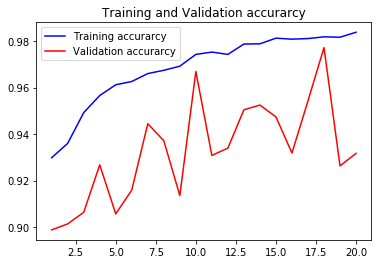

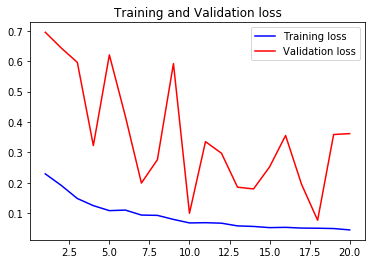

In [53]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Model Accuracy

In [54]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
591/591 [==============================] - 29s 49ms/step
Test Accuracy: 93.1754104780465


Save model using Pickle

In [55]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...


In [56]:
loaded_model = pickle.load(open('cnn_model.pkl', 'rb'))

In [85]:
image_dir="../input/plantdisease/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG"
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [86]:
result=model.predict(npp_image)
print(result)

[[8.0920237e-01 1.0933936e-01 3.2156364e-03 1.0793479e-05 4.8782505e-05
  8.6893670e-05 3.1984220e-03 6.8914428e-02 2.6948749e-08 8.1977453e-07
  5.9842517e-07 1.0118356e-08 5.9814625e-03 5.4054805e-09 3.6696653e-07]]


In [87]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.8092024
Pepper__bell___Bacterial_spot


In [88]:
x = label_binarizer.classes_[itemindex[1][0]]
x

'Pepper__bell___Bacterial_spot'

In [92]:
if(x=='Potato___Early_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Pepper__bell___Bacterial_spot'):
    print("use copper sprays")
if(x=='Potato___Late_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Tomato_Bacterial_spot'):
    print("use copper sprays")
if(x=='Tomato_Early_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Tomato_Late_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Tomato_Leaf_Mold'):
    print("use chladosporium fulvum")
if(x=='Tomato_Septoria_leaf_spot'):
    print("use fungicides")

use copper sprays


In [93]:
image_dir="../input/plantdisease/PlantVillage/Potato___Late_blight/0085ef03-aec3-431a-99a1-de286e10c0cf___RS_LB 2949.JPG"
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [94]:
result=model.predict(npp_image)
print(result)

[[7.1398630e-03 4.3592171e-04 7.0253634e-03 6.1931247e-01 2.1299833e-01
  6.5639270e-03 3.9374265e-03 1.2258803e-01 1.2442685e-07 2.3142068e-06
  3.2790209e-05 2.4789449e-07 1.9963128e-02 5.6742831e-08 5.4092673e-08]]


In [95]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.61931247
Potato___Late_blight


In [96]:
x = label_binarizer.classes_[itemindex[1][0]]
x

'Potato___Late_blight'

In [97]:
if(x=='Potato___Early_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Pepper__bell___Bacterial_spot'):
    print("use copper sprays")
if(x=='Potato___Late_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Tomato_Bacterial_spot'):
    print("use copper sprays")
if(x=='Tomato_Early_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Tomato_Late_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Tomato_Leaf_Mold'):
    print("use chladosporium fulvum")
if(x=='Tomato_Septoria_leaf_spot'):
    print("use fungicides")

use mancozeb and cholorathalonil


In [98]:
image_dir="../input/plantdisease/PlantVillage/Tomato_healthy/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.JPG"
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [99]:
result=model.predict(npp_image)
print(result)

[[2.8328073e-10 9.9087649e-10 1.2873499e-09 1.3048640e-10 1.3722327e-07
  1.6941160e-05 1.0337776e-09 4.2312305e-09 3.3443928e-11 1.5580341e-14
  4.5545789e-10 2.1689665e-10 8.5536644e-09 2.0108108e-11 9.9998295e-01]]


In [100]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.99998295
Tomato_healthy


In [101]:
x = label_binarizer.classes_[itemindex[1][0]]
x

'Tomato_healthy'

In [102]:
if(x=='Potato___Early_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Pepper__bell___Bacterial_spot'):
    print("use copper sprays")
if(x=='Potato___Late_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Tomato_Bacterial_spot'):
    print("use copper sprays")
if(x=='Tomato_Early_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Tomato_Late_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Tomato_Leaf_Mold'):
    print("use chladosporium fulvum")
if(x=='Tomato_Septoria_leaf_spot'):
    print("use fungicides")
if(x=='Potato___healthy' or x=='Tomato_healthy' or x=='Pepper__bell___healthy'):
    print("healthy plant")

healthy plant


In [103]:
image_dir="../input/plantdisease/PlantVillage/Pepper__bell___healthy/00100ffa-095e-4881-aebf-61fe5af7226e___JR_HL 7886.JPG"
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [104]:
result=model.predict(npp_image)
print(result)

[[6.1651247e-07 9.9995553e-01 8.5446246e-09 8.5166867e-13 7.8322074e-07
  7.3097062e-09 6.8107097e-06 3.3239870e-05 2.5706960e-12 2.5500182e-09
  3.6139316e-09 7.3001745e-13 2.9596717e-06 8.1671458e-12 3.2373870e-10]]


In [105]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.99995553
Pepper__bell___healthy


In [106]:
x = label_binarizer.classes_[itemindex[1][0]]
x

'Pepper__bell___healthy'

In [107]:
if(x=='Potato___Early_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Pepper__bell___Bacterial_spot'):
    print("use copper sprays")
if(x=='Potato___Late_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Tomato_Bacterial_spot'):
    print("use copper sprays")
if(x=='Tomato_Early_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Tomato_Late_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Tomato_Leaf_Mold'):
    print("use chladosporium fulvum")
if(x=='Tomato_Septoria_leaf_spot'):
    print("use fungicides")
if(x=='Potato___healthy' or x=='Tomato_healthy' or x=='Pepper__bell___healthy'):
    print("healthy plant")

healthy plant


In [108]:
image_dir="../input/plantdisease/PlantVillage/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG"
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [109]:
result=model.predict(npp_image)
print(result)

[[2.1969288e-06 1.2447368e-08 9.9813133e-01 3.2567471e-09 8.5272995e-12
  1.2782117e-06 1.8563912e-03 6.8208064e-06 9.2998291e-12 3.0010100e-10
  4.2802906e-10 8.8359775e-15 2.0135326e-06 2.0138557e-11 4.3881365e-09]]


In [110]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.99813133
Potato___Early_blight


In [111]:
x = label_binarizer.classes_[itemindex[1][0]]
x

'Potato___Early_blight'

In [112]:
if(x=='Potato___Early_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Pepper__bell___Bacterial_spot'):
    print("use copper sprays")
if(x=='Potato___Late_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Tomato_Bacterial_spot'):
    print("use copper sprays")
if(x=='Tomato_Early_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Tomato_Late_blight'):
    print("use mancozeb and cholorathalonil")
if(x=='Tomato_Leaf_Mold'):
    print("use chladosporium fulvum")
if(x=='Tomato_Septoria_leaf_spot'):
    print("use fungicides")
if(x=='Potato___healthy' or x=='Tomato_healthy' or x=='Pepper__bell___healthy'):
    print("healthy plant")

use mancozeb and cholorathalonil
